<h1><font size=12>
Weather Derivatites </h1>
<h1> Neural Network Transition <br></h1>

Developed by [Jesus Solano](mailto:ja.solano588@uniandes.edu.co) <br>  
22 September 2018 


In [1]:
# Import needed libraries. 
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
import time
from io import StringIO
import datetime 
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Import Datasets

In [2]:
# Import total dataset. 
# Configure path to read txts.

path = '../datasets/'

# Download the update dataset.

import os

if not os.path.exists(path+'/fullDataset/completeDailyDataset.pickle'):

  ! wget https://github.com/jesugome/WeatherDerivates/raw/master/datasets/fullDataset/completeDailyDataset.pickle -P path 

allDataDataframe = pickle.load(open(path+'/fullDataset/completeDailyDataset.pickle','rb'))

In [3]:
allDataDataframe.head()

,Prep,Month,nino34,probNeutral,probNino,probNina,state,nextState
2005-01-01,0,1,0.606186,0.15,0.85,0,0,0
2005-01-02,0,1,0.599358,0.15,0.85,0,0,0
2005-01-03,0,1,0.646784,0.15,0.85,0,0,1
2005-01-04,1.6,1,0.663696,0.15,0.85,0,1,0
2005-01-05,0,1,0.71133,0.15,0.85,0,0,0


In [4]:
# Normalize DataFrame
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(allDataDataframe) 
allDataDataframe.loc[:,:] = scaled_values
allDataDataframe.head()

,Prep,Month,nino34,probNeutral,probNino,probNina,state,nextState
2005-01-01,0.000000,0.0,0.495221,0.15,0.85,0.0,0.0,0.0
2005-01-02,0.000000,0.0,0.493935,0.15,0.85,0.0,0.0,0.0
2005-01-03,0.000000,0.0,0.502863,0.15,0.85,0.0,0.0,1.0
2005-01-04,0.020382,0.0,0.506047,0.15,0.85,0.0,1.0,0.0
2005-01-05,0.000000,0.0,0.515014,0.15,0.85,0.0,0.0,0.0


# Preparing Datasets

In [5]:
# Split original data into 0's and 1's (Dry and wet days).

dryDays = allDataDataframe[allDataDataframe['state']==0]
wetDays = allDataDataframe[allDataDataframe['state']==1]

In [10]:
# Create X and Y training matrices(dry). 

xDry = dryDays.drop(['nextState','state','Prep','probNeutral','nino34'],axis=1)

xtrainD = xDry.values

test = pd.DataFrame(xtrain)

#xtrainD = np.reshape(xtrain, ( xtrain.shape[0], 1 , xtrain.shape[1]))


yDry = dryDays['nextState']
ytrainD = yDry.values

#ytrainD = np.reshape(ytrain, (ytrain.shape[0] , ) )

print(xtrainD.shape, ' --  ' ,ytrainD.shape)

(1741, 3)  --   (1741,)


In [11]:
# Create X and Y training matrices(Wet). 

xWet = wetDays.drop(['nextState','state','probNeutral','nino34'],axis=1)

xtrainW = xWet.values

test = pd.DataFrame(xtrain)

#xtrainW = np.reshape(xtrain, ( xtrain.shape[0], 1 , xtrain.shape[1]))


yWet = wetDays['nextState']
ytrainW = yWet.values

#ytrainW = np.reshape(ytrain, (ytrain.shape[0] , ) )

print(xtrainW.shape, ' --  ' ,ytrainW.shape)

(2275, 4)  --   (2275,)


In [12]:
# Split dataset.
xTrainD, xValidationD, yTrainD, yValidationD = train_test_split(xtrainD, ytrainD, test_size=0.25, random_state=22)
xTrainW, xValidationW, yTrainW, yValidationW = train_test_split(xtrainW, ytrainW, test_size=0.25, random_state=22)

# Neural Network

In [13]:
# Import neural networks libraries.
from  keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Flatten, Dropout, Activation, BatchNormalization, LSTM
from keras import optimizers as opts
from keras.callbacks import History
from keras.layers import Conv1D, GlobalMaxPooling1D
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


### Dry 

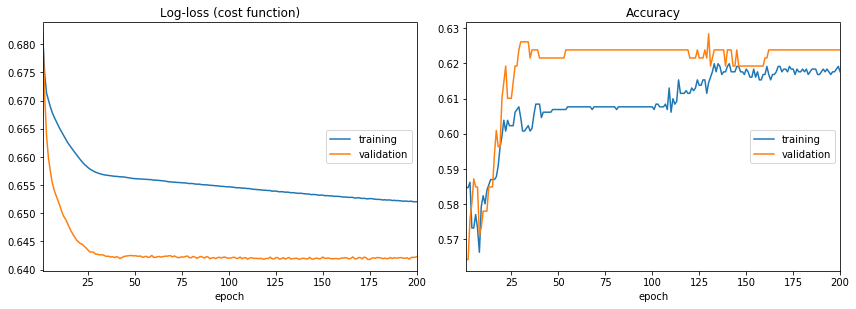

In [18]:
from keras import backend as K
K.clear_session()

model = Sequential()
model.add(Dense(50, input_dim = xtrainD.shape[1], activation= 'relu'))
model.add(Dense(1, activation='sigmoid'))

#Defines optimizer.
op = opts.adam(lr=0.01)

model.compile(loss='binary_crossentropy', optimizer=op, metrics=['accuracy'])

model.summary()

batch_size = 365
epochs = 200

#model.fit(xtrain, ytrain, validation_split=0.1, batch_size=2000, epochs=50, verbose=1, callbacks=[PlotLossesKeras()])

model.fit(xTrainD, yTrainD,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle = False, 
                    validation_data = [xValidationD,yValidationD],
                    #validation_split = 0.1,
                    callbacks=[PlotLossesKeras()])

model.save('../results/visibleMarkov/rainfall_lstmDry.h5')

In [19]:

from sklearn.metrics import roc_curve, auc, roc_auc_score

yPred = model.predict(xValidationD)
AUC = roc_auc_score(yValidationD, yPred)
# Perform the neural network over the test set. 

print('Evaluating the test set...')
score = model.evaluate(xValidationD, yValidationD)
#roc_curve(yValidationTxt,yPredGenre)

print('\nTest score:', score[0])
print('Test accuracy:', score[1])
print('Model AUC is: ', AUC )

Evaluating the test set...
436/436 [==============================] - 0s 84us/step

Test score: 0.6422959216144106
Test accuracy: 0.6238532115560059
Model AUC is:  0.6623983739837398


### Wet

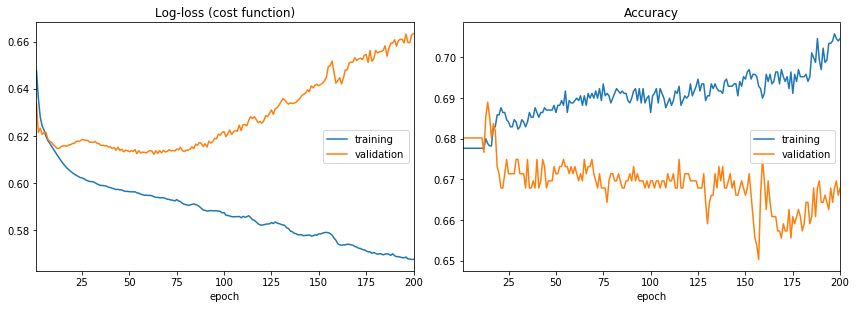

In [21]:
from keras import backend as K
K.clear_session()

model = Sequential()
model.add(Dense(50, input_dim = xtrainW.shape[1], activation= 'relu'))
model.add(Dense(25, activation= 'relu'))
model.add(Dense(1, activation='sigmoid'))

#Defines optimizer.
op = opts.adam(lr=0.01)

model.compile(loss='binary_crossentropy', optimizer=op, metrics=['accuracy'])

model.summary()

batch_size = 365
epochs = 200

#model.fit(xtrain, ytrain, validation_split=0.1, batch_size=2000, epochs=50, verbose=1, callbacks=[PlotLossesKeras()])

model.fit(xTrainW, yTrainW,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle = False, 
                    validation_data = [xValidationW,yValidationW],
                    #validation_split = 0.1,
                    callbacks=[PlotLossesKeras()])

model.save('../results/visibleMarkov/rainfall_lstmWet.h5')

In [22]:

from sklearn.metrics import roc_curve, auc, roc_auc_score

yPred = model.predict(xValidationW)
AUC = roc_auc_score(yValidationW, yPred)
# Perform the neural network over the test set. 

print('Evaluating the test set...')
score = model.evaluate(xValidationW, yValidationW)
#roc_curve(yValidationTxt,yPredGenre)

print('\nTest score:', score[0])
print('Test accuracy:', score[1])
print('Model AUC is: ', AUC )

Evaluating the test set...
569/569 [==============================] - 0s 89us/step

Test score: 0.6633793972498084
Test accuracy: 0.6678383140865655
Model AUC is:  0.6091802254592952


In [29]:
xValidationD.shape

(436, 1, 3)

In [32]:
val = np.array([0.1, 0.85, 0.14])

In [33]:
val.shape

(3,)

In [34]:
xt = np.reshape(val, ( 1, 1 , val.shape[0]))

In [35]:
xt.shape

(1, 1, 3)

In [36]:
xWet

,Prep,Month,probNino,probNina
2005-01-04,0.020382,0.000000,0.85,0.0
2005-01-10,0.005096,0.000000,0.85,0.0
2005-01-14,0.005096,0.000000,0.85,0.0
2005-01-15,0.002548,0.000000,0.85,0.0
2005-01-16,0.014013,0.000000,0.85,0.0
2005-01-17,0.003822,0.000000,0.85,0.0
2005-01-20,0.025478,0.000000,0.85,0.0
2005-01-28,0.012739,0.000000,0.85,0.0
2005-01-29,0.030573,0.000000,0.85,0.0
2005-01-31,0.021656,0.000000,0.85,0.0
